In [9]:
import json
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Example list of file paths - replace with your actual file paths

def find_json_files(directory_path, entropy):
    matching_files = []
    if not os.path.isdir(directory_path):
        print(f"The directory {directory_path} does not exist.")
        return matching_files
    for file in os.listdir(directory_path):
        if file.startswith(f"embedding_{entropy}") and file.endswith('.json'):
            full_path = os.path.join(directory_path, file)
            matching_files.append(full_path)
    return matching_files

def load_embedding_vectors(file_paths):

    # Initialize a dictionary to hold your vectors
    vectors_dict = {}

    # Loop through each file
    for file_path in file_paths:
        # Extract vector identifiers from the filename
        base_name = os.path.basename(file_path)
        parts = base_name.split('-')
        
        third_vector_id = f"{parts[1]}-{parts[2]}"
        fourth_vector_id = f"{parts[-2]}-{parts[-1].split('.')[0]}"  # Remove '.json'

        # Load the JSON content
        with open(file_path, 'r') as file:
            vectors = json.load(file)
            
        vectors_dict[parts[1]] = vectors[0]
        vectors_dict[parts[-2]] = vectors[1]

        # Extract the 3rd and 4th vectors and add them to the dictionary
        vectors_dict[third_vector_id] = vectors[2]  # 3rd vector
        vectors_dict[fourth_vector_id] = vectors[3]  # 4th vector
        
    return vectors_dict

def create_dot_product_table(embeddings):
    embeddings_array = np.stack(embeddings)
    dot_product_table = np.dot(embeddings_array, embeddings_array.T)
    return dot_product_table


def visualize_dot_product_table(dot_product_table, keys):
    """
    Visualizes the dot product table with labels.
    
    Args:
    - dot_product_table: 2D NumPy array of dot products.
    - keys: List of identifiers corresponding to each row/column in the dot product table.
    """
    plt.figure(figsize=(10, 8))  # Optional: Adjust the figure size as needed
    ax = sns.heatmap(dot_product_table, xticklabels=keys, yticklabels=keys, annot=False, cmap='viridis')
    plt.title('Dot Product Table Visualization')
    plt.xlabel('Vector Key')
    plt.ylabel('Vector Key')
    plt.show()

['./embeddings/entropy_5/embedding_5-1-1_1--5-2-1_1.json', './embeddings/entropy_5/embedding_5-1-1_1--5-2-2_1.json', './embeddings/entropy_5/embedding_5-1-1_1--5-2-3_1.json', './embeddings/entropy_5/embedding_5-1-2_1--5-2-1_1.json', './embeddings/entropy_5/embedding_5-1-2_1--5-2-2_1.json', './embeddings/entropy_5/embedding_5-1-2_1--5-2-3_1.json', './embeddings/entropy_5/embedding_5-1-3_1--5-2-1_1.json', './embeddings/entropy_5/embedding_5-1-3_1--5-2-2_1.json', './embeddings/entropy_5/embedding_5-1-3_1--5-2-3_1.json']


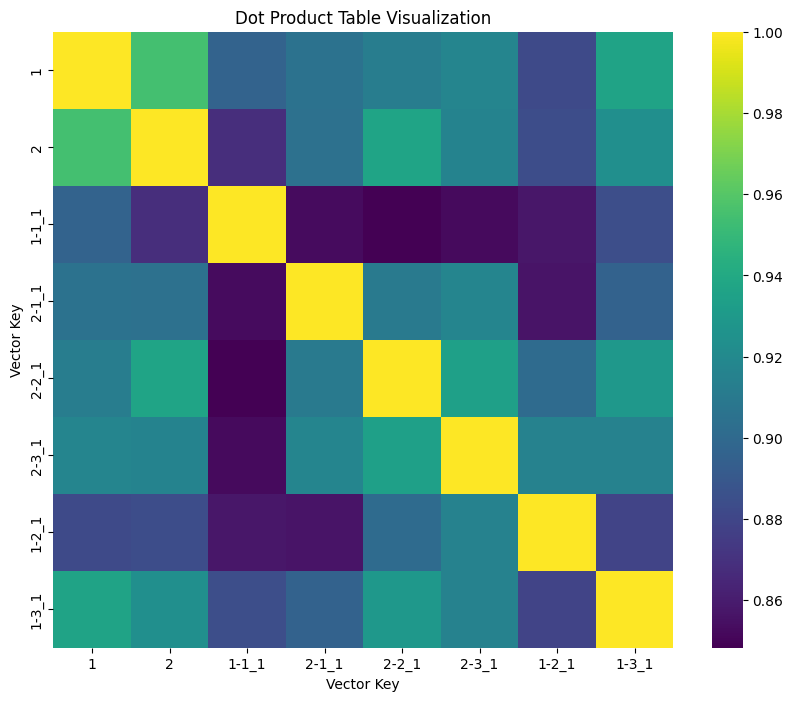

In [10]:
file_paths = find_json_files('./embeddings/entropy_5/', 5)
print(file_paths)
vectors_dict = load_embedding_vectors(file_paths)
embeddings = list(vectors_dict.values())  # Extract the embedding vectors from the dictionary
keys = list(vectors_dict.keys())  # Extract the keys (identifiers)
dot_products = create_dot_product_table(embeddings)

visualize_dot_product_table(dot_products, keys)

In [32]:
# Assume 'dot_product_table' is the numpy array of your dot product values
# and 'keys' is the list of keys corresponding to the rows/columns of this table.

# Filter the keys to identify the indices for each group
group_1_indices = [i for i, key in enumerate(keys) if key.startswith('1')]
group_2_indices = [i for i, key in enumerate(keys) if key.startswith('2')]

# Calculate the average dot product within each group
average_similarity_group_1 = np.mean([dot_products[i, j] for i in group_1_indices for j in group_1_indices if i != j])
average_similarity_group_2 = np.mean([dot_products[i, j] for i in group_2_indices for j in group_2_indices if i != j])

# Print the results
print(f'Average similarity within group 1: {average_similarity_group_1}')
print(f'Average similarity within group 2: {average_similarity_group_2}')

# Determine which group has higher intra-group similarity
more_similar_group = '2' if average_similarity_group_2 > average_similarity_group_1 else '1'
print(f'Keys that start with "{more_similar_group}" are more similar to each other.')


Average similarity within group 1: 0.7175637311842292
Average similarity within group 2: 0.9043294273451677
Keys that start with "2" are more similar to each other.


In [33]:
# Calculate the average dot product between the groups
average_intergroup_similarity = np.mean([dot_products[i, j] for i in group_1_indices for j in group_2_indices])

# Print the results
print(f'Average intergroup similarity: {average_intergroup_similarity}')

Average intergroup similarity: 0.798046903824808


In [34]:
from sklearn.cluster import KMeans

# Assuming 'embeddings' is your list of embedding vectors
# and 'keys' is a list of the original keys corresponding to each embedding

# Decide the number of clusters
k = 2  # Example for two clusters, adjust based on your data

# Perform K-means clustering
kmeans = KMeans(n_clusters=k, random_state=0).fit(embeddings)

# The cluster labels for each point
labels = kmeans.labels_

# Create a dictionary to hold the cluster assignment for each key
clusters = {i: [] for i in range(k)}  # Initialize with empty lists for each cluster

# Assign keys to their respective clusters
for key, label in zip(keys, labels):
    clusters[label].append(key)

# Now 'clusters' is a dictionary where each key is a cluster index
# and the value is a list of keys that are assigned to that cluster

for cluster, cluster_keys in clusters.items():
    print(f"Cluster {cluster}: {cluster_keys}")


Cluster 0: ['1', '2', '1-3_1', '2-2_1', '2-1_1', '2-4']
Cluster 1: ['1-4_1']


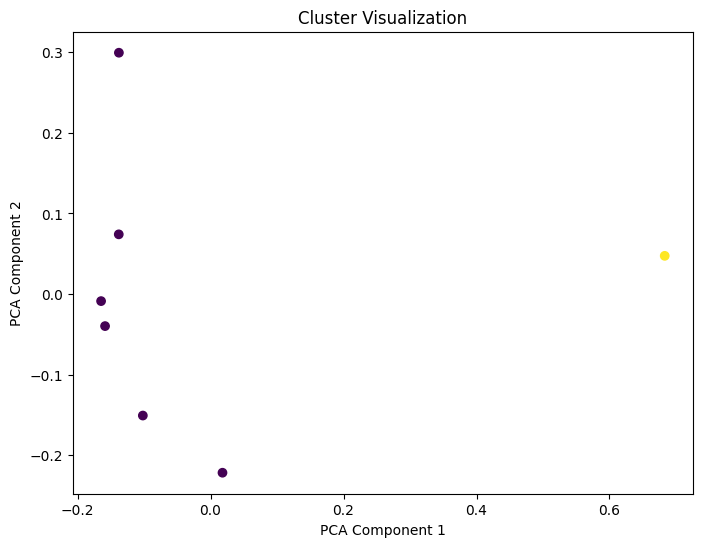

In [35]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce to two dimensions for visualization
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Plot the reduced data with labels
plt.figure(figsize=(8, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='viridis', marker='o')
plt.title('Cluster Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

# Show the cluster centers if desired
# for center in cluster_centers:
#     reduced_center = pca.transform([center])
#     plt.scatter(reduced_center[:, 0], reduced_center[:, 1], c='red', s=100, marker='x')

plt.show()
